In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e8/sample_submission.csv
/kaggle/input/playground-series-s5e8/train.csv
/kaggle/input/playground-series-s5e8/test.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold,train_test_split,GridSearchCV,learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve,auc,accuracy_score,confusion_matrix
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
plt.rc("font",family="SimHei",size="15")  
pd.set_option('display.precision',4)

In [3]:
train_backup = pd.read_csv('/kaggle/input/playground-series-s5e8/train.csv')
test_backup = pd.read_csv('/kaggle/input/playground-series-s5e8/test.csv')

In [4]:
train_df = pd.read_csv('/kaggle/input/playground-series-s5e8/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s5e8/test.csv')

In [5]:
train_df.head(10)

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1
5,5,24,admin.,single,secondary,no,1882,yes,no,cellular,20,apr,1010,3,-1,0,unknown,0
6,6,39,blue-collar,married,secondary,no,0,no,no,telephone,21,nov,90,1,-1,0,unknown,0
7,7,50,admin.,single,secondary,no,1595,no,no,telephone,31,jul,49,25,-1,0,unknown,0
8,8,46,blue-collar,married,primary,no,1463,no,no,cellular,4,aug,50,1,-1,0,unknown,0
9,9,39,management,divorced,tertiary,no,25,yes,no,cellular,8,may,119,1,-1,0,unknown,0


In [6]:
test_df.head(10)

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,750000,32,blue-collar,married,secondary,no,1397,yes,no,unknown,21,may,224,1,-1,0,unknown
1,750001,44,management,married,tertiary,no,23,yes,no,cellular,3,apr,586,2,-1,0,unknown
2,750002,36,self-employed,married,primary,no,46,yes,yes,cellular,13,may,111,2,-1,0,unknown
3,750003,58,blue-collar,married,secondary,no,-1380,yes,yes,unknown,29,may,125,1,-1,0,unknown
4,750004,28,technician,single,secondary,no,1950,yes,no,cellular,22,jul,181,1,-1,0,unknown
5,750005,43,management,divorced,unknown,no,3025,no,no,cellular,21,jul,89,2,-1,0,unknown
6,750006,26,services,single,primary,no,3511,no,no,cellular,29,jan,816,3,-1,0,unknown
7,750007,60,management,married,tertiary,no,79,no,yes,cellular,9,jul,707,1,-1,0,unknown
8,750008,45,blue-collar,married,primary,no,16,no,no,telephone,6,feb,173,1,-1,0,unknown
9,750009,41,management,married,tertiary,no,46,no,no,cellular,18,aug,657,4,-1,0,unknown


In [7]:
train_df.columns

Index(['id', 'age', 'job', 'marital', 'education', 'default', 'balance',
       'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign',
       'pdays', 'previous', 'poutcome', 'y'],
      dtype='object')

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         750000 non-null  int64 
 1   age        750000 non-null  int64 
 2   job        750000 non-null  object
 3   marital    750000 non-null  object
 4   education  750000 non-null  object
 5   default    750000 non-null  object
 6   balance    750000 non-null  int64 
 7   housing    750000 non-null  object
 8   loan       750000 non-null  object
 9   contact    750000 non-null  object
 10  day        750000 non-null  int64 
 11  month      750000 non-null  object
 12  duration   750000 non-null  int64 
 13  campaign   750000 non-null  int64 
 14  pdays      750000 non-null  int64 
 15  previous   750000 non-null  int64 
 16  poutcome   750000 non-null  object
 17  y          750000 non-null  int64 
dtypes: int64(9), object(9)
memory usage: 103.0+ MB


In [9]:
train_df.isnull().sum()

id           0
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [10]:
train_df.describe().style.format('{:.3f}')

,id,age,balance,day,duration,campaign,pdays,previous,y
count,750000.000,750000.000,750000.000,750000.000,750000.000,750000.000,750000.000,750000.000,750000.000
mean,374999.500,40.926,1204.067,16.117,256.229,2.577,22.413,0.299,0.121
std,216506.495,10.099,2836.097,8.251,272.556,2.719,77.320,1.336,0.326
min,0.000,18.000,-8019.000,1.000,1.000,1.000,-1.000,0.000,0.000
25%,187499.750,33.000,0.000,9.000,91.000,1.000,-1.000,0.000,0.000
50%,374999.500,39.000,634.000,17.000,133.000,2.000,-1.000,0.000,0.000
75%,562499.250,48.000,1390.000,21.000,361.000,3.000,-1.000,0.000,0.000
max,749999.000,95.000,99717.000,31.000,4918.000,63.000,871.000,200.000,1.000


In [11]:
sample_submission = pd.read_csv('/kaggle/input/playground-series-s5e8/sample_submission.csv')
sample_submission.head(10)

,id,y
0,750000,0.5
1,750001,0.5
2,750002,0.5
3,750003,0.5
4,750004,0.5
5,750005,0.5
6,750006,0.5
7,750007,0.5
8,750008,0.5
9,750009,0.5


In [12]:
train_num_df = train_df.select_dtypes(include='number').drop(columns=['id'])
train_num_df.corr()
#.style.format('{:.4f}')

,age,balance,day,duration,campaign,pdays,previous,y
age,1.0000,0.0628,-0.0152,-0.0044,0.0021,-0.0216,0.0045,0.0095
balance,0.0628,1.0000,-0.0083,0.1096,-0.0277,0.0100,0.0339,0.1225
day,-0.0152,-0.0083,1.0000,-0.0568,0.1788,-0.0862,-0.0511,-0.0496
duration,-0.0044,0.1096,-0.0568,1.0000,-0.0830,0.0476,0.0401,0.5193
campaign,0.0021,-0.0277,0.1788,-0.0830,1.0000,-0.0615,-0.0267,-0.0758
pdays,-0.0216,0.0100,-0.0862,0.0476,-0.0615,1.0000,0.5618,0.0893
previous,0.0045,0.0339,-0.0511,0.0401,-0.0267,0.5618,1.0000,0.1196
y,0.0095,0.1225,-0.0496,0.5193,-0.0758,0.0893,0.1196,1.0000


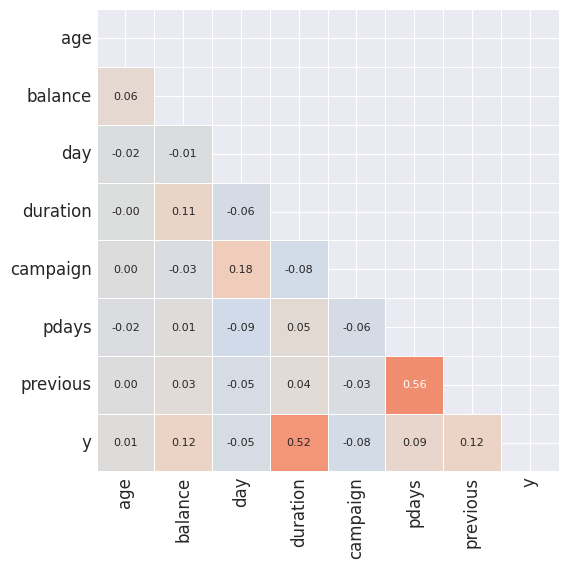

In [13]:
mask = np.triu(np.ones_like(train_num_df.corr(), dtype=bool))
plt.figure(figsize = (8,6))
plt.rcParams.update({'font.size': 12})
sns.heatmap(train_num_df.corr(), cmap = 'coolwarm', vmin = -1, 
            vmax = 1, center = 0, annot=True, fmt=".2f", square=True, linewidths=.5, mask = mask,
             annot_kws={'size': 8}, cbar=False
           )
plt.show()


<Axes: title={'center': 'Boxplot'}>

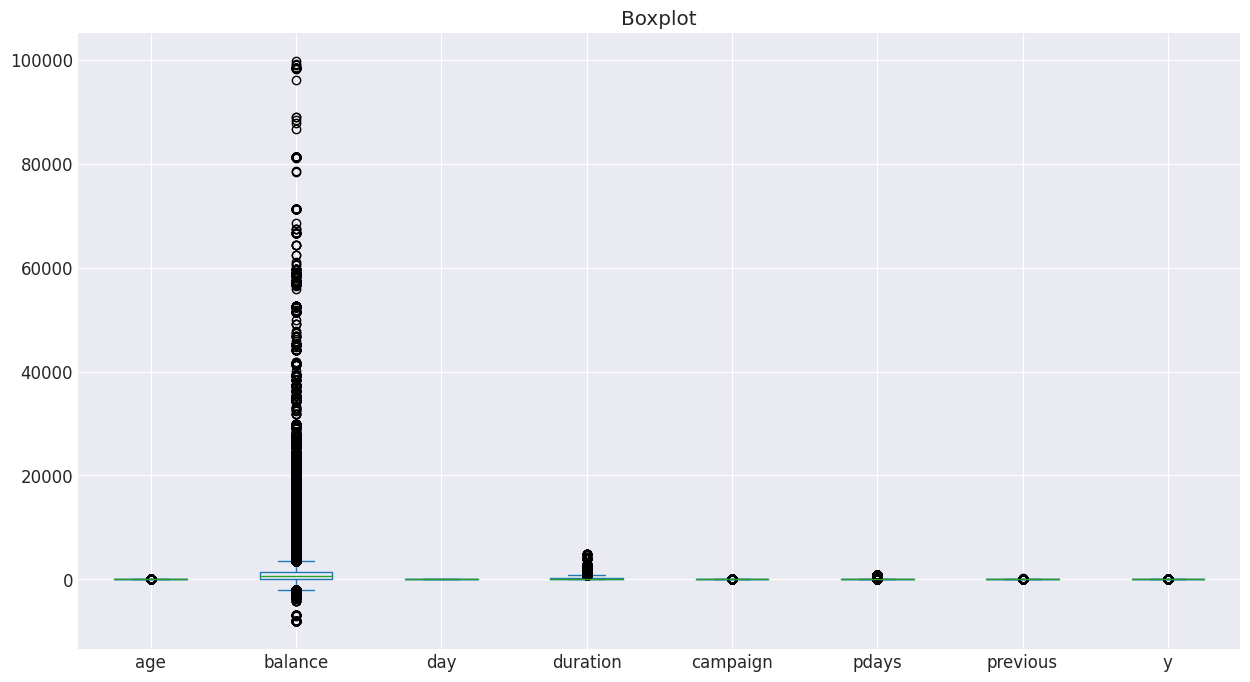

In [14]:
train_num_df.plot(kind='box', title='Boxplot', figsize=(15, 8))

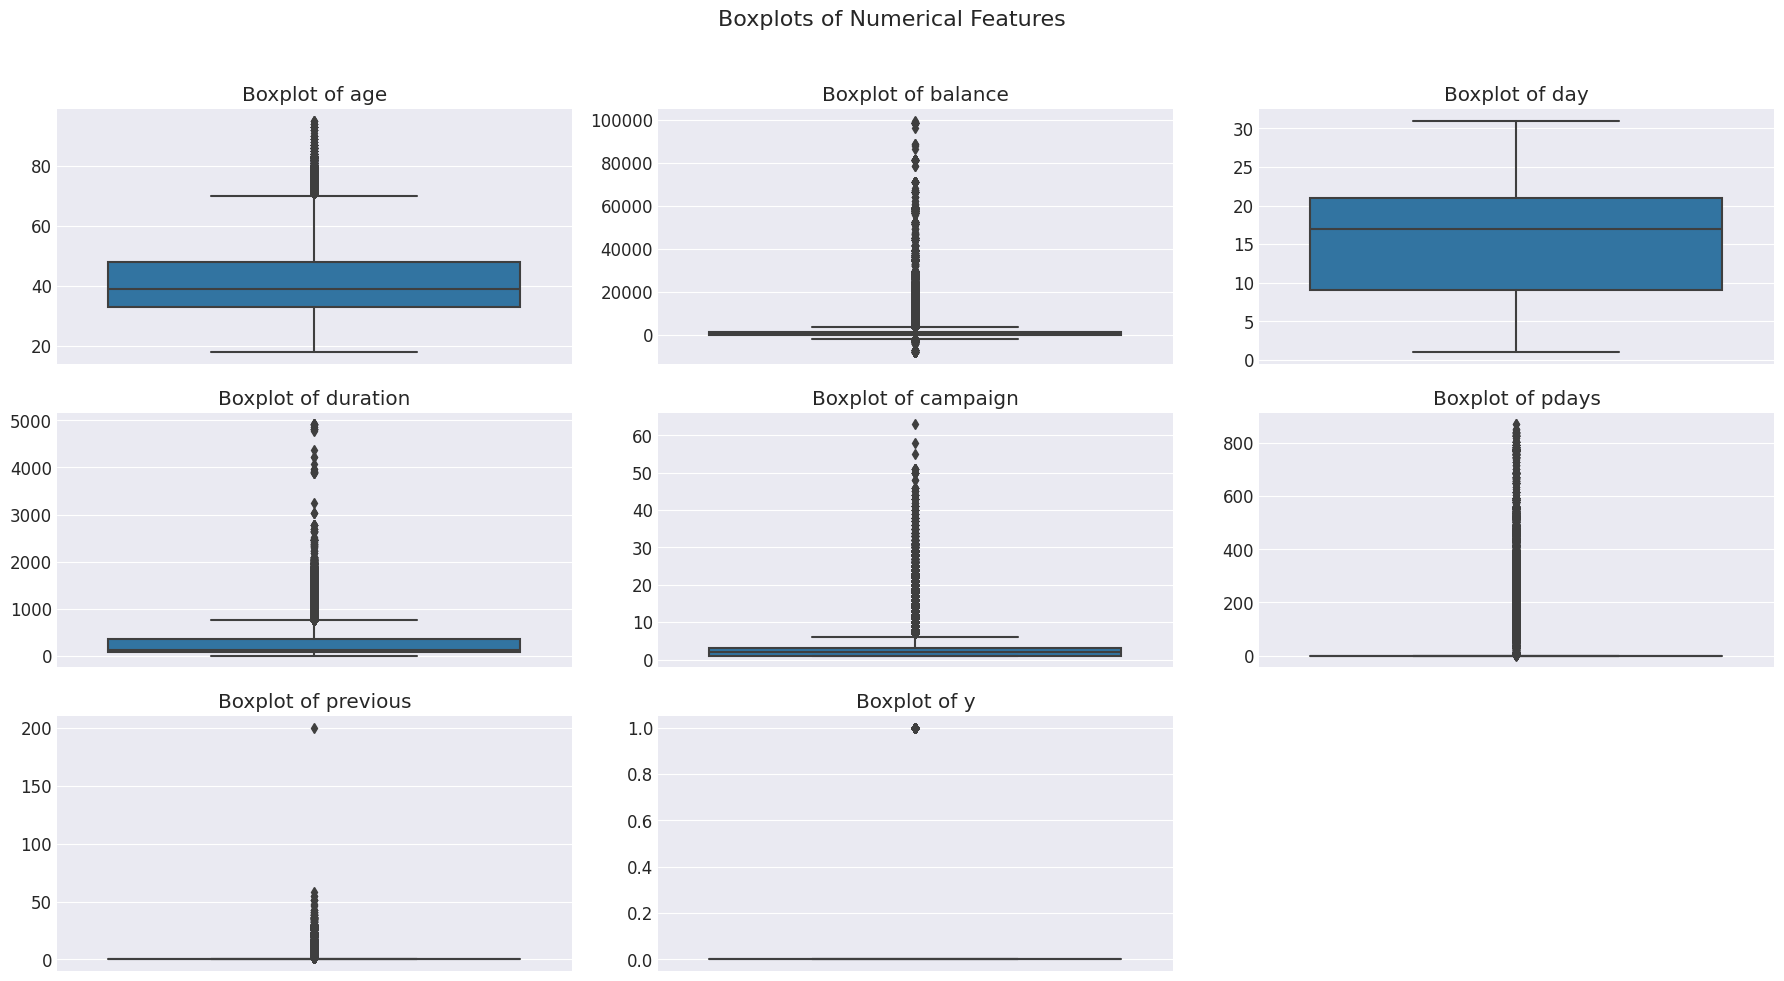

In [15]:
import math
num_cols = len(train_num_df.columns)
n_cols = 3
n_rows = math.ceil(num_cols / n_cols)

# 2. Create the figure and axes objects
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 10))
# Flatten the axes array to make it easy to iterate over
axes = axes.flatten()

# 3. Loop through the columns and plot
for i, col in enumerate(train_num_df.columns):
    sns.boxplot(y=col, data=train_num_df, ax=axes[i], orient='v')
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_ylabel('') # Optional: remove y-label for cleaner look

# 4. Remove any unused subplots
for i in range(num_cols, len(axes)):
    fig.delaxes(axes[i])

# 5. Add a main title and adjust layout
fig.suptitle('Boxplots of Numerical Features', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust rect to make space for suptitle
plt.show()

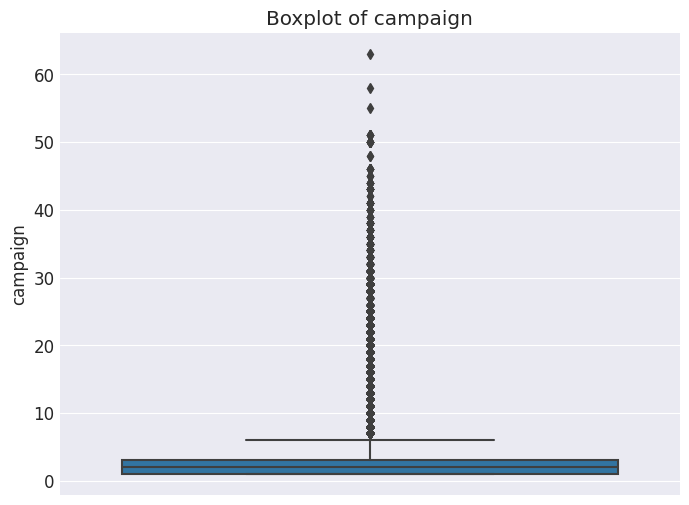

In [16]:
# Logic for extreme outlier case
plt.figure(figsize=(8, 6))
sns.boxplot(y='campaign', data=train_num_df)
plt.title('Boxplot of campaign')
plt.show()

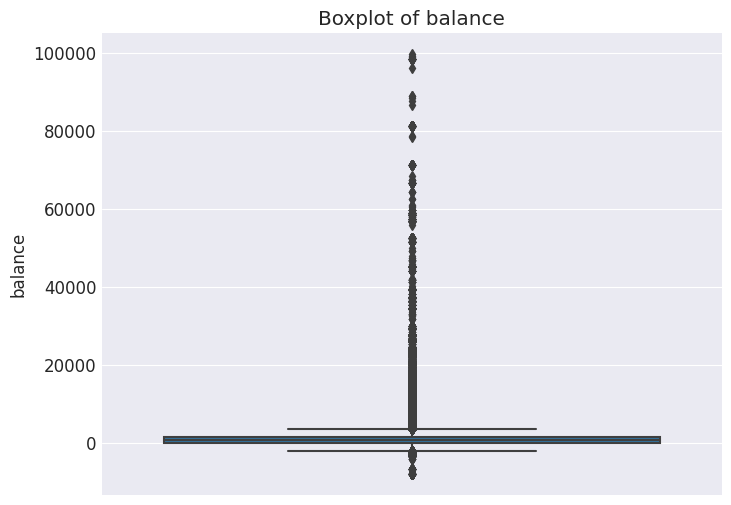

In [17]:
# Logic for extreme outlier case
plt.figure(figsize=(8, 6))
sns.boxplot(y='balance', data=train_num_df)
plt.title('Boxplot of balance')
plt.show()

In [18]:
other_cols = train_num_df.drop(columns=['campaign','balance'])
